## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# import warnings and filter 
import warnings
warnings.filterwarnings("ignore")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open("../input/complaints/complaints-2021-05-14_08_16.json") # Write the path to your data file and load it 

# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# set options to display max rows and max columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.head()

(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#print the column names
print(len(df.columns))
df.columns

22


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
# create new column names as the old column names have unnecessary information

new_col_names = list(map(lambda x : x.lstrip('_') if x.startswith('_') else x, list(df.columns)))

new_col_names = list(map(lambda x : x.replace('source.', "") if x.startswith('source.') else x, new_col_names))

print(len(new_col_names))
new_col_names

22


['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [8]:
#Assign new column names
df.columns = new_col_names
print(df.columns)

# check the head of the dataframe
df.head()

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
# Check the % missing values
round(100*(df.isnull().sum()/len(df)), 2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [10]:
#Assign nan in place of blanks in the complaints column

df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x : np.nan if x == "" else x)

In [11]:
# check the missing values again
round(100*(df.isnull().sum()/len(df)), 2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

#### Now we see that there a missing values in complaint_what_happened column after replacing blanks with NaNs

In [12]:
#Remove all rows where complaints column is nan
df_final = df[~(df.complaint_what_happened.isna())]

# Check the % of missing values again
round(100*(df_final.isnull().sum()/len(df_final)), 2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         81.89
zip_code                     22.04
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         0.68
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  10.01
timely                        0.00
complaint_what_happened       0.00
sub_issue                    38.80
consumer_consent_provided     0.00
dtype: float64

In [13]:
# Final shape of the dataframe after removing NaN values
df_final.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_complaint(column):
    # convert the text to lowercase
    df_final[column] = df_final[column].apply(lambda x : x.lower())     
    
    # removing text which is present in square brackets using the regex
    df_final[column] = df_final[column].apply(lambda x : re.sub('\[(.*?)\]', "", x))
    
    # removing all the punctuations from the text using the regex
    p = "[" + re.escape(string.punctuation) + "]"
    df_final[column] = df_final[column].apply(lambda x : re.sub(p, "", x))
    
    # removing words which contains digits/numbers
    df_final[column] = df_final[column].apply(lambda x : re.sub('\S*\d+\S*', "", x))    


In [15]:
# Print a sentence 
print(df_final['complaint_what_happened'][1])

# Apply the above function on the complaint_what_happened column
clean_complaint('complaint_what_happened')

# print the same sentence after cleaning it 
df_final['complaint_what_happened'][1]

Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. 
In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. 
I have a right to know this information as a consumer. 

Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.


'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

### Swifter is a package which efficiently applies any function to a pandas dataframe or series in the fastest available manner.

##### Since in our code, we are using lemmatization and POS tagging in the next steps, there's a high chance that it might take lot of time. Hence we will install swifter in the next step and use it while applying lemmatization and POS extraction

In [16]:
!pip install swifter

In [17]:
# create a new model with disbaling the not useful components from the pipeline to conserve time
#from tqdm import tqdm
model = spacy.load('en_core_web_sm',disable=['parser','ner'])

# Import swifter (the above downloaded package)
import swifter

In [18]:
#Write your function to Lemmatize the texts

# Here we are using the WordNetLemmatizer to lemmatize each word of a sentence.
# Also, lets skip lemmatizing for stop words since they aren't useful and also conserve time

def lemmatize(text):      
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [19]:
# apply the above created function on the complaint_what_happened column to extract the lemmatized complaint

df_final['lem_complaint'] = df_final['complaint_what_happened'].swifter.apply(lambda x : lemmatize(x))
df_final['lem_complaint'][0:5]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

1     good morning name xxxx xxxx appreciate could h...
2     upgraded xxxx xxxx card told agent upgrade ann...
10    chase card reported however fraudulent applica...
11    trying book xxxx xxxx ticket came across offer...
14    grand son give check deposit chase account fun...
Name: lem_complaint, dtype: object

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame({'Complaint' : df_final['complaint_what_happened'], 
                         'Lem_complaint' : df_final['lem_complaint']})
print(df_clean.shape)

(21072, 2)


In [21]:
# check the head of the df_clean dataframe
df_clean.head()

,Complaint,Lem_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [22]:
#Write your function to extract the POS tags 
# here we are using spacy's model to extract the POS tags. 

# Also, we will use only Nouns/Proper Nouns in the given text to create a new sentence 
# This is because the importance of the sentence is mainly measured by nouns

def pos_tag(sentence):
    noun_words = []
    doc = model(sentence)
    
    for token in doc:
        if token.pos_ == 'NOUN' or token.pos_ == 'PROPN':
            noun_words.append(token.text)
            
    nouns_sent = " ".join(noun_words)        
    return nouns_sent

In [23]:
# create new column Noun_complaint by applying the above created function on complaint_what_happened column

df_clean['Noun_complaint'] = df_clean['Complaint'].swifter.apply(lambda x : pos_tag(x))
df_clean['Noun_complaint'][0:5]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

1     morning name xxxx xxxx stop bank cardmember se...
2     xxxx xxxx card agent anniversary date agent in...
10    chase card application identity consent servic...
11    xxxx xxxx ticket offer ticket rewards card inf...
14    son chase account fund chase bank account mone...
Name: Noun_complaint, dtype: object

In [24]:
# storing the dataframe in a temporary variable 
temp1 = df_clean

In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,Complaint,Lem_complaint,Noun_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...


In [26]:
# print a sample sentence and its other forms like lemma and nouns extracted sentence

print(df_clean['Complaint'][1])
print(df_clean['Lem_complaint'][1])
print(df_clean['Noun_complaint'][1])


good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help
good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help
morning name xxxx xxxx stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase xxxx xxxx xxxx xxxx thanks advance help


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [27]:
# create a list with the length of each sentence in the text corpus
comp_sent_len = [len(x) for x in df_clean['Complaint']]
noun_comp_sent_len = [len(x) for x in df_clean['Noun_complaint']]

print(len(comp_sent_len))
print(len(noun_comp_sent_len))


21072
21072


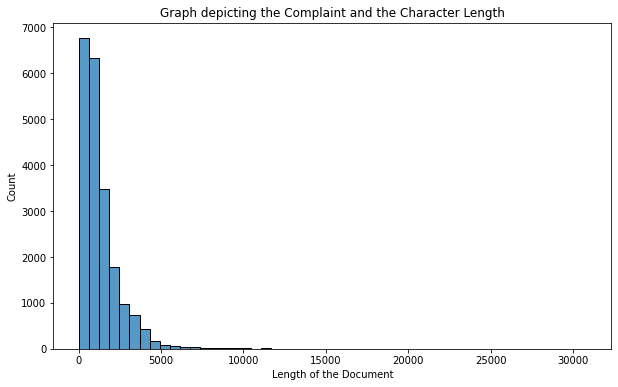

In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
sns.histplot(comp_sent_len, bins= 50)
plt.title("Graph depicting the Complaint and the Character Length")
plt.xlabel("Length of the Document")
plt.show()

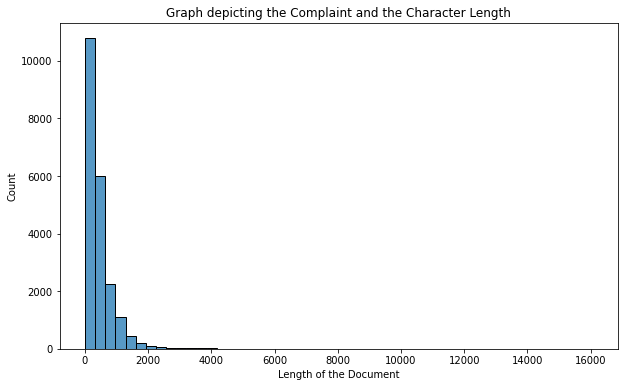

In [29]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
sns.histplot(noun_comp_sent_len, bins= 50)
plt.title("Graph depicting the Complaint and the Character Length")
plt.xlabel("Length of the Document")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [30]:
# installing wordcloud which is used to visualize the top 40 words of the text corpus
!pip install wordcloud

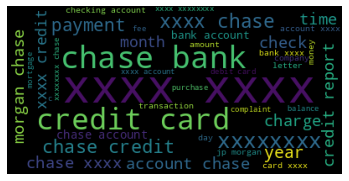

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
#list of stop words
stoplist = set(stopwords.words("english"))

# create the word cloud object
wc = WordCloud(stopwords=stoplist,max_words=40, background_color='black').generate(str(df_clean.Noun_complaint))

print(wc)
# plot the wordcloud object
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
plt.show();


In [32]:
#Removing -PRON- from the text corpus because pronouns' lemmatized version is set as -PRON- sometimes
df_clean['Complaint_clean'] = df_clean['Noun_complaint'].str.replace('-PRON-', '')

In [33]:
# check the df_clean head
df_clean.head()

,Complaint,Lem_complaint,Noun_complaint,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,morning name xxxx xxxx stop bank cardmember se...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...,xxxx xxxx card agent anniversary date agent in...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,xxxx xxxx ticket offer ticket rewards card inf...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


In [34]:
# storing the dataframe in a temp variable
temp2 = df_clean

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [35]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# Use the CountVectorizer function to get the unigram words
def get_unigrams(docs, n):
    vector = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each unigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of unigrams by calling the above defined function
unigrams = get_unigrams(df_clean['Noun_complaint'], 30)

In [36]:
#Print the top 10 words in the unigram frequency
unigrams_df = pd.DataFrame(unigrams, columns=['word', 'count'])
unigrams_df.head(10)

,word,count
0,xxxx,188217
1,chase,74129
2,account,41213
3,credit,32225
4,xxxxxxxx,27869
5,card,26805
6,bank,26408
7,payment,13963
8,time,11967
9,money,11941


In [37]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

# Use the CountVectorizer function to get the bigram words
def get_bigrams(docs, n):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each bigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of bigram words and frequency by calling the above func
bigrams = get_bigrams(df_clean['Noun_complaint'], 30)

In [38]:
#Print the top 10 words in the bigram frequency
bigrams_df = pd.DataFrame(bigrams, columns=['word', 'count'])
bigrams_df.head(10)

,word,count
0,xxxx xxxx,89257
1,chase bank,12110
2,credit card,10961
3,xxxx chase,6644
4,chase xxxx,4411
5,xxxxxxxx xxxx,4286
6,account xxxx,3824
7,xxxx xxxxxxxx,3630
8,account chase,3442
9,chase credit,3398


In [39]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

# Use the CountVectorizer function to get the trigram words
def get_trigrams(docs, n):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each trigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of trigram words and frequency by calling the above func
trigrams = get_trigrams(df_clean['Noun_complaint'], 30)

In [40]:
#Print the top 10 words in the trigram frequency

trigrams_df = pd.DataFrame(trigrams, columns=['word', 'count'])
trigrams_df.head(10)

,word,count
0,xxxx xxxx xxxx,45825
1,xxxx xxxx chase,3075
2,xxxxxxxx xxxx xxxx,2142
3,chase credit card,1996
4,chase xxxx xxxx,1735
5,xxxx xxxx xxxxxxxx,1711
6,jp morgan chase,1596
7,account xxxx xxxx,1515
8,chase bank xxxx,1338
9,xxxx xxxxxxxx xxxx,1231


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [41]:
# remove the xxxx terms from the compalints column
df_clean['Noun_complaint'] = df_clean['Noun_complaint'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [42]:
# storing the df in a tep variable 
temp3 = df_clean

In [43]:
#All masked texts has been removed
df_clean.head(10)

,Complaint,Lem_complaint,Noun_complaint,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services d...,morning name stop bank cardmember services d...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
15,can you please remove inquiry,please remove inquiry,inquiry,inquiry
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...
20,during the summer months i experience a declin...,summer month experience decline income due emp...,summer months decline income employment month ...,summer months decline income employment month ...
21,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using chase ...,payment retailer chase pay chase website sca...,payment retailer chase pay chase website sca...
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,credit card data credit report company issue,credit card data credit report company issue


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [44]:
#Write your code here to initialise the TfidfVectorizer 

tfidf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

tf_fit = tfidf_vect.fit(df_clean.Complaint_clean)

#df_tfidf = tf_fit.transform(df_clean.Complaint_clean) 


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [45]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_mat = tf_fit.transform(df_clean.Complaint_clean)

In [46]:
# get the list of features 
features = list(tf_fit.get_feature_names())
len(features)

8291

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [47]:
# import NMF
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [48]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40) 

In [49]:
# create two matrices W and H 
# W - Doc-Topic matrix
# H - Topic-Term Matrix

W = nmf_model.fit_transform(doc_term_mat)
H = nmf_model.components_

In [50]:
#Print the Top15 words for each of the topics

# get the feature names
words = np.array(tf_fit.get_feature_names())

# create a dataframe with featues and the topic-term matrix H
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,bank,chase,check,money,funds,branch,checking,deposit,accounts,business,number,days,checks,fraud
Topic 1,credit,report,inquiry,card,inquiries,score,cards,accounts,chase,account,debt,reporting,limit,information,bureaus
Topic 2,loan,mortgage,chase,home,modification,property,payments,foreclosure,years,bank,house,letter,rate,morgan,time
Topic 3,card,chase,charges,charge,credit,dispute,fraud,merchant,transaction,company,fee,purchase,phone,service,number
Topic 4,payment,payments,balance,month,fees,fee,statement,date,auto,time,chase,days,account,months,day


In [51]:
# print the shapes of W and H matrices
print(W.shape)
print(H.shape)

(21072, 5)
(5, 8291)


In [52]:
#  Dataframe form of Doc-Topic matrix 
W_df = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics) ])
W_df.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,0.013888,0.014935,0.017521,0.005850,0.008681
1,0.007433,0.001489,0.000878,0.019887,0.003801
2,0.000000,0.038315,0.001566,0.028375,0.000000
3,0.020373,0.053543,0.015886,0.025098,0.000000
4,0.069583,0.000000,0.008394,0.007448,0.000000


In [53]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.argmax(axis=1)

In [54]:
df_clean.head()

,Complaint,Lem_complaint,Noun_complaint,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services d...,morning name stop bank cardmember services d...,2
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...,3
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,1
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [55]:
#Print the first 5 Complaint for each of the Topics
df_clean_sort = df_clean.groupby('Topic').head(5)
df_clean_sort.sort_values('Topic')

,Complaint,Lem_complaint,Noun_complaint,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account chase bank code bonus terms account...,account chase bank code bonus terms account...,0
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...,0
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto,account chase auto,0
30,to whom it may concern chase bank charged wron...,may concern chase bank charged wrongly overdra...,concern chase bank overdraft fees alert balanc...,concern chase bank overdraft fees alert balanc...,0
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,1
15,can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,credit card data credit report company issue,credit card data credit report company issue,1
26,i have reached out to xxxx several times in at...,reached xxxx several time attempt fraudulent i...,times attempt inquiry creditor inquiry report...,times attempt inquiry creditor inquiry report...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [56]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0 : 'Bank Account services',
                1 : 'Credit card or prepaid card' ,
                2 : 'Mortgage/ Loan',
                3 : 'Theft/Dispute Reporting' , 
                4 : 'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [57]:
# Head of the dataframe
df_clean.head()

,Complaint,Lem_complaint,Noun_complaint,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services d...,morning name stop bank cardmember services d...,Mortgage/ Loan
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [58]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services' : 0,
                'Credit card or prepaid card' : 1 ,
                'Mortgage/ Loan' : 2 ,
                'Theft/Dispute Reporting' : 3 , 
                'Others' : 4}
#Replace Topics with Topic Names
df_clean['Topic_Number'] = df_clean['Topic'].map(Topic_names)

In [59]:
df_clean.head()

,Complaint,Lem_complaint,Noun_complaint,Complaint_clean,Topic,Topic_Number
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services d...,morning name stop bank cardmember services d...,Mortgage/ Loan,2
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...,Theft/Dispute Reporting,3
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,Credit card or prepaid card,1
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,Credit card or prepaid card,1
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank Account services,0


In [60]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['Complaint', 'Topic_Number']]

In [61]:
training_data.head()

,Complaint,Topic_Number
1,good morning my name is xxxx xxxx and i apprec...,2
2,i upgraded my xxxx xxxx card in and was told ...,3
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [62]:
#Write your code here to transform the word vector to tf-idf

X = tf_fit.transform(training_data['Complaint'])

#Shape of the Predictor Variables
X.shape

(21072, 8291)

In [63]:
#Shape of the Response Variable
Y = training_data['Topic_Number']
Y.shape

(21072,)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## APPLYING LOGISTIC REGRESSION

### Since our data pre-processing has been performed, we can proceed with the model building

In [64]:
# install yellowbrick to visualize ROC curve of a multiclass problem
!pip install yellowbrick

In [65]:
# Modeling librarries
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix


from sklearn import metrics
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC

# define the multinomial logistic regression model

lr = LogisticRegression(multi_class='ovr', solver='liblinear')


In [66]:
#test-train split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=50)

In [67]:
X_train.shape

(15804, 8291)

In [68]:
#fitting the model on train data

lr_model = lr.fit(X_train, y_train)

In [69]:
# make predictions on train set 

pred_dept_train = lr_model.predict(X_train)

In [70]:
# make predictions on test set 

pred_dept_test = lr_model.predict(X_test)

In [71]:
#pringting the performance metrics for train data
print(metrics.classification_report(y_train, pred_dept_train ))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4228
           1       0.96      0.94      0.95      2583
           2       0.98      0.96      0.97      2795
           3       0.95      0.97      0.96      4520
           4       0.97      0.90      0.93      1678

    accuracy                           0.96     15804
   macro avg       0.96      0.95      0.96     15804
weighted avg       0.96      0.96      0.96     15804



In [72]:
#pringting the performance metrics for test data
print(metrics.classification_report(y_test, pred_dept_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1404
           1       0.96      0.91      0.93       870
           2       0.95      0.93      0.94       912
           3       0.92      0.94      0.93      1548
           4       0.95      0.83      0.88       534

    accuracy                           0.93      5268
   macro avg       0.94      0.92      0.93      5268
weighted avg       0.93      0.93      0.93      5268



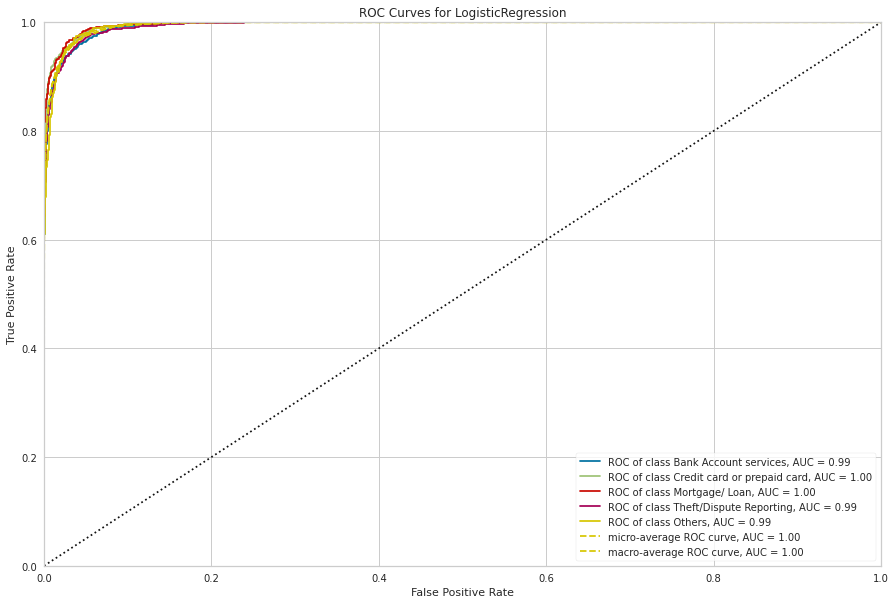

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [73]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(lr, encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"})

visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test) 
visualizer.show()

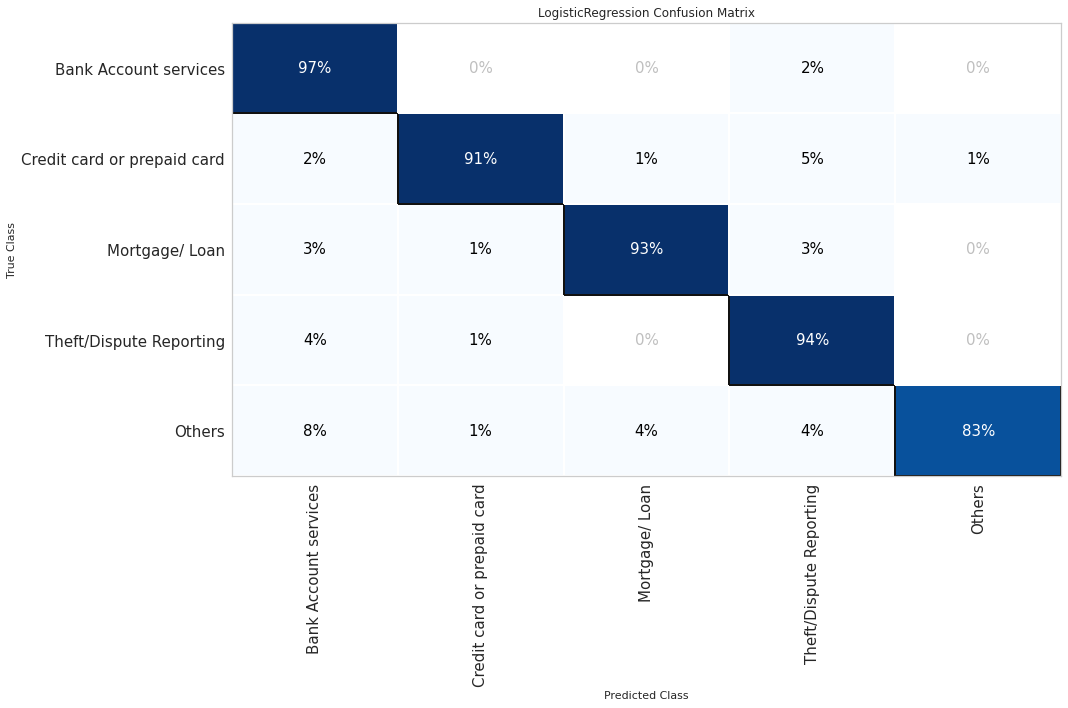

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [74]:
#visualizing the Confusion Matrix for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ConfusionMatrix(lr,
                             encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"},
                             percent=True,
                             cmap="Blues",
                             fontsize=15)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Observations : Logistic Regression

* Accuracy = 0.93
* Precision (weighted-avg) = 0.93
* Recall (weighted-avg) = 0.93
* F1-score = 0.93

**Overall this model gives us great results as indicated by the above performance metrics**


## APPLYING RANDOM-FOREST CLASSIFIER

In [75]:
#importing required libraries

from sklearn.ensemble import RandomForestClassifier

In [76]:
# Initialize a simple Random Forest Classifier

rf = RandomForestClassifier(n_estimators=15, max_depth=20, max_features=30, random_state=100, 
                            oob_score=True)

In [77]:
#creating a copy of test train data for the Random Forest Classifier

X1_train = X_train
Y1_train = y_train
X1_test = X_test
Y1_test = y_test

In [78]:
#fitting a simple random forest classifier on train data

rf.fit(X1_train, Y1_train)

#printing the oob score
rf.oob_score_

0.5856112376613516

In [79]:
#predicting the class labels on the train data
y1_pred_train=rf.predict(X1_train)

In [80]:
#predicting the class labels on the test data

y1_pred_test = rf.predict(X1_test)

In [81]:
#printing the performance metrics for the train data

print(metrics.classification_report(Y1_train, y1_pred_train))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      4228
           1       0.90      0.58      0.70      2583
           2       0.92      0.71      0.81      2795
           3       0.62      0.93      0.74      4520
           4       0.99      0.25      0.39      1678

    accuracy                           0.75     15804
   macro avg       0.84      0.67      0.69     15804
weighted avg       0.80      0.75      0.73     15804



In [82]:
#printing the performance metrics for the test data

print(metrics.classification_report(Y1_test, y1_pred_test))

              precision    recall  f1-score   support

           0       0.65      0.79      0.72      1404
           1       0.86      0.45      0.59       870
           2       0.87      0.62      0.72       912
           3       0.54      0.85      0.67      1548
           4       0.83      0.05      0.10       534

    accuracy                           0.65      5268
   macro avg       0.75      0.55      0.56      5268
weighted avg       0.71      0.65      0.62      5268



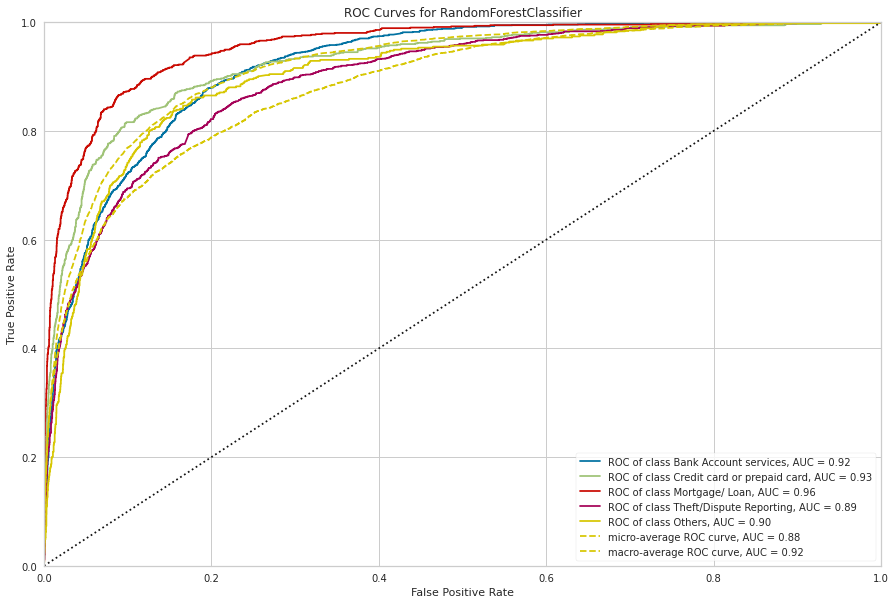

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [83]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(rf, encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"})

visualizer.fit(X1_train,Y1_train)
visualizer.score(X1_test,Y1_test) 
visualizer.show()

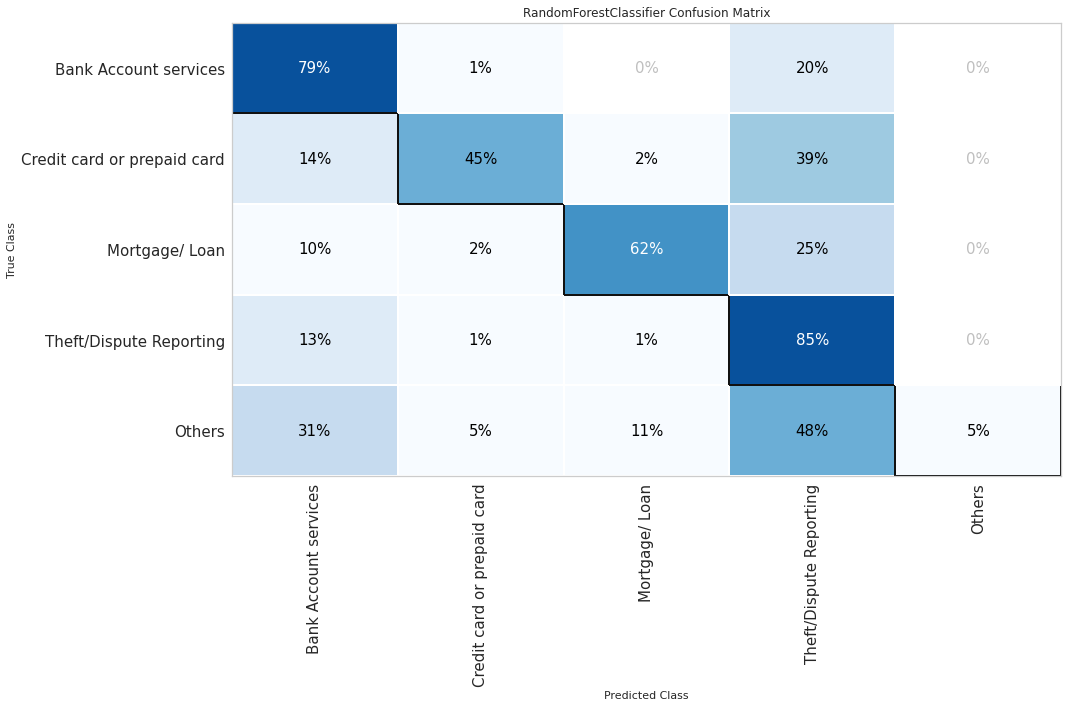

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [84]:
#visualizing the Confusion Matrix for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ConfusionMatrix(rf,
                             encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"},
                             percent=True,
                             cmap="Blues",
                             fontsize=15)

visualizer.fit(X1_train, Y1_train)
visualizer.score(X1_test, Y1_test)
visualizer.show()

## Observations : Random-Forest Classifier

* Accuracy = 0.65
* Precision (weighted-avg) = 0.71
* Recall (weighted-avg) = 0.65
* F1-score = 0.62

**The Random Forest model doesn't produce the results better than the Logistic Model**

**The two classes 'Credit Card or Prepaid Loan' and 'Others' have very poor perfomance metrics and the misclassification percenatge is 55% and 52% respectively**

**Let's try Random-Forest model with Hyperparameter Tuning**


## APPLYING RANDOM FOREST CLASSIFIER WITH HYPERPARAMETER TUNING

In [85]:
#Intializing a RaondForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

#Defining the training hyper-parameters
params = {
    'max_depth': [20,35,40],
    'min_samples_leaf': [100,200],
    'max_features':[500,1000],
    'n_estimators': [50]
}

In [86]:
#instantiating a grid_seach_cv object with 3 folds and accuracy for scoring
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [87]:
#fitting the above defined model
grid_search.fit(X1_train, Y1_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.4min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [20, 35, 40], 'max_features': [500, 1000],
                         'min_samples_leaf': [100, 200], 'n_estimators': [50]},
             scoring='accuracy', verbose=1)

In [88]:
#printing the accuracy score of the best fit model
grid_search.best_score_

0.832953682611997

In [89]:
#preserving the best fit model in rf_best
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, max_features=1000, min_samples_leaf=100,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [90]:
#instantitatin the RandomForestClassifier with best fit parameters

rf_best = RandomForestClassifier(max_depth=20, max_features=1000, min_samples_leaf=100,
                       n_estimators=50, n_jobs=-1, random_state=42, oob_score=True)
#fitting the model on train data
rf_best.fit(X1_train,Y1_train)

RandomForestClassifier(max_depth=20, max_features=1000, min_samples_leaf=100,
                       n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=42)

In [91]:
#printing the oob score

rf_best.oob_score_

0.8285244241964059

In [92]:
#predicting the class labels for train and test data
predicted_rf_train = rf_best.predict(X1_train)
predicted_rf_test = rf_best.predict(X1_test)

In [93]:
#printing performance metrics for train data

print(metrics.classification_report(Y1_train, predicted_rf_train))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4228
           1       0.88      0.77      0.82      2583
           2       0.91      0.84      0.88      2795
           3       0.81      0.90      0.85      4520
           4       0.89      0.69      0.77      1678

    accuracy                           0.85     15804
   macro avg       0.87      0.82      0.84     15804
weighted avg       0.86      0.85      0.85     15804



In [94]:
#printing performance metrics for test data

print(metrics.classification_report(Y1_test, predicted_rf_test))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1404
           1       0.90      0.74      0.82       870
           2       0.90      0.85      0.87       912
           3       0.81      0.88      0.84      1548
           4       0.84      0.66      0.74       534

    accuracy                           0.84      5268
   macro avg       0.85      0.81      0.83      5268
weighted avg       0.84      0.84      0.84      5268



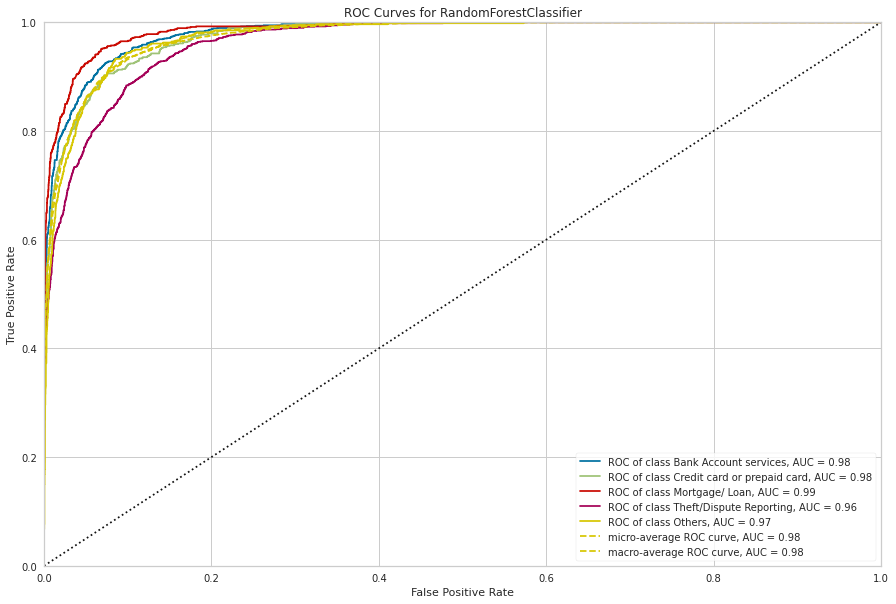

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [95]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(rf_best, encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"})

visualizer.fit(X1_train,Y1_train)
visualizer.score(X1_test, Y1_test) 
visualizer.show()

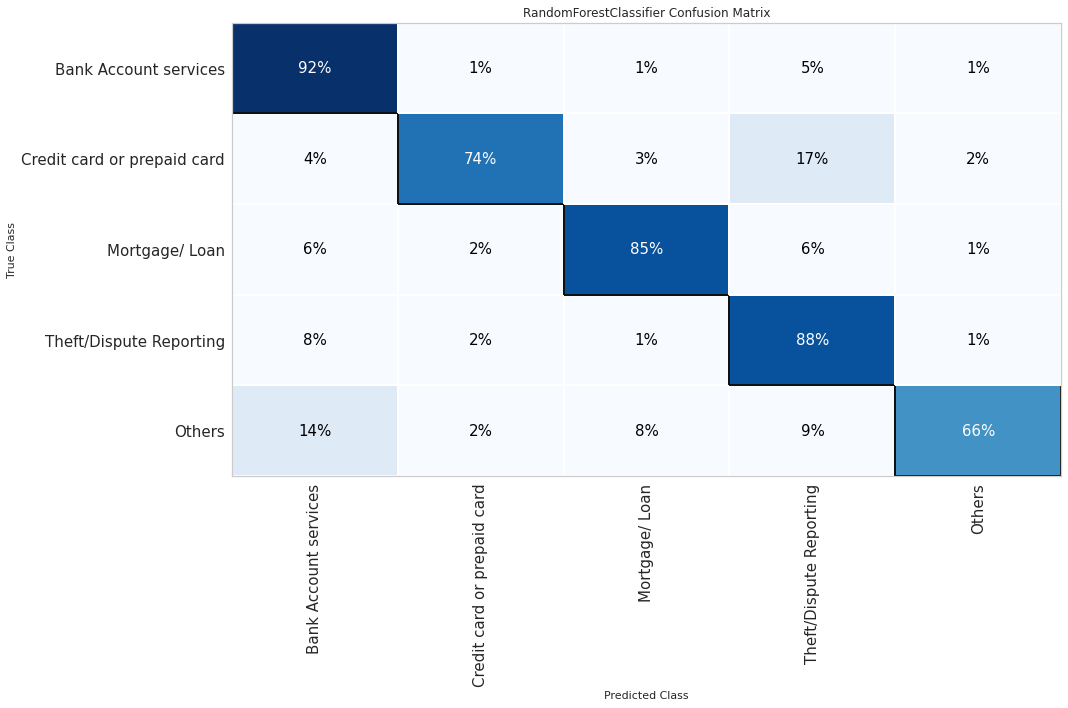

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [96]:
#visualizing the Confusion Matrix for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ConfusionMatrix(rf_best,
                             encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"},
                             percent=True,
                             cmap="Blues",
                             fontsize=15)

visualizer.fit(X1_train, Y1_train)
visualizer.score(X1_test, Y1_test)
visualizer.show()

## Observations : Random-Forest Classifier with HyperParameter Tuning

* Accuracy = 0.84
* Precision (weighted-avg) = 0.84
* Recall (weighted-avg) = 0.84
* F1-score = 0.84

**The Random Forest model with Hyperparameter tuning certainly shows a great improvement in the performance metrics**

**The two classes 'Credit Card or Prepaid Loan' and 'Others' which had poor perfomance metrics and the high misclassification percenatge now show an improvement**

**Let's try Naive Bayes and see if we get any further improvement**


## APPLYING NAIVE BAYES ALGORITHM

In [97]:
#importing the required libraries
from sklearn.naive_bayes import MultinomialNB

In [98]:
#initializing a multinomial-naive-bayes classifier

mnb = MultinomialNB()

#fitting the model on Train Data
mnb.fit(X1_train, Y1_train)

MultinomialNB()

In [99]:
#predicting the class labels for train and test data

ytrain_pred_mnb = mnb.predict(X1_train)
ytest_pred_mnb = mnb.predict(X1_test)

In [100]:
#printing performance metrics for test data

print(metrics.classification_report(Y1_train, ytrain_pred_mnb))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84      4228
           1       0.85      0.66      0.74      2583
           2       0.86      0.87      0.86      2795
           3       0.75      0.90      0.81      4520
           4       0.91      0.32      0.47      1678

    accuracy                           0.79     15804
   macro avg       0.83      0.73      0.74     15804
weighted avg       0.81      0.79      0.78     15804



In [101]:
#printing perfomance metrics for test data

print(metrics.classification_report(Y1_test, ytest_pred_mnb))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1404
           1       0.85      0.65      0.73       870
           2       0.83      0.85      0.84       912
           3       0.72      0.85      0.78      1548
           4       0.87      0.23      0.37       534

    accuracy                           0.76      5268
   macro avg       0.80      0.69      0.70      5268
weighted avg       0.78      0.76      0.74      5268



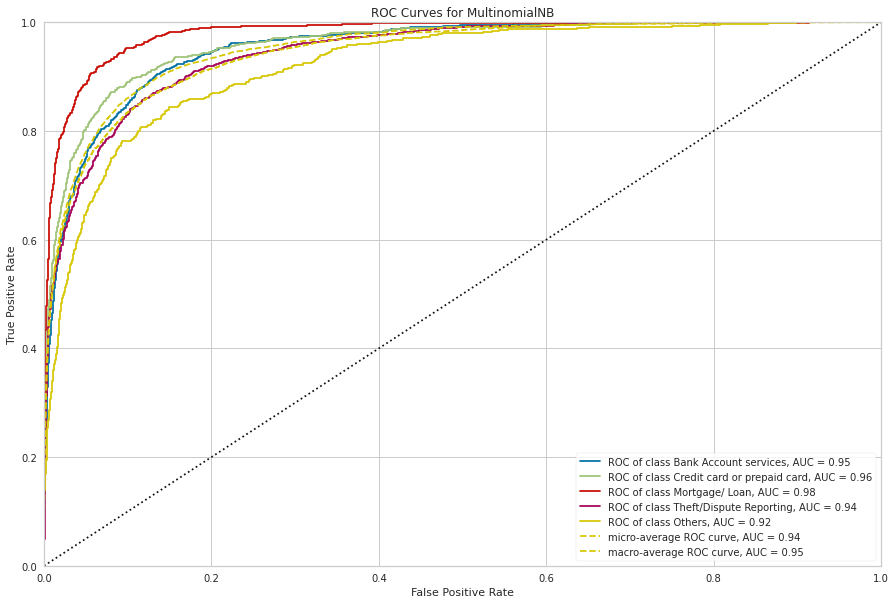

<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [102]:
#visualizing the ROCAUC curve and the score for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ROCAUC(mnb, encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"})

visualizer.fit(X1_train,Y1_train)
visualizer.score(X1_test, Y1_test) 
visualizer.show()

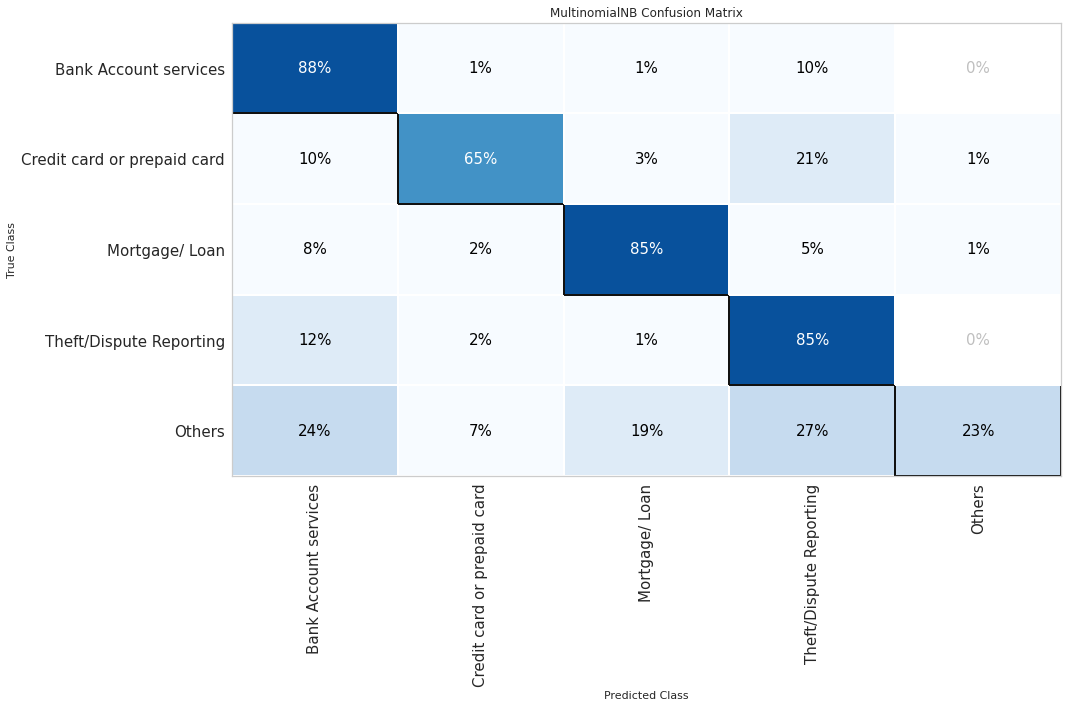

<AxesSubplot:title={'center':'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [103]:
#visualizing the Confusion Matrix for all the 5 class labels

fig = plt.figure(figsize=(15,10))

visualizer = ConfusionMatrix(mnb,
                             encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"},
                             percent=True,
                             cmap="Blues",
                             fontsize=15)

visualizer.fit(X1_train, Y1_train)
visualizer.score(X1_test, Y1_test)
visualizer.show()

## Observations : Naive Bayes with Multinomial Classification

* Accuracy = 0.76
* Precision (weighted-avg) = 0.78
* Recall (weighted-avg) = 0.76
* F1-score = 0.74
 
**The Naive Bayes Model has reasonable results but the two classes 'Credit Card or Prepaid Card' and 'Others' have concerns with misclassification perentage in the test data.**

**Let's Compare all the above models and try to pick the best one**


## CHOOSING BEST MODEL

In [104]:
#creating the metrics dataframe for all the above run models
metrics = pd.DataFrame({'Model': ['Logistic Regression', 'Random-Forest', 'Random-Forest with Hyperparameter Tuning', 'Naive Bayes'],
                        'Accuracy': [0.93, 0.65, 0.84, 0.76],
                        'Precision': [0.93, 0.71, 0.84, 0.78],
                        'Recall': [0.93, 0.65, 0.84, 0.76],
                        'F1-Score': [0.93, 0.62, 0.84, 0.74]}  )

In [105]:
#printing the overall metrics
metrics

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.93,0.93,0.93,0.93
1,Random-Forest,0.65,0.71,0.65,0.62
2,Random-Forest with Hyperparameter Tuning,0.84,0.84,0.84,0.84
3,Naive Bayes,0.76,0.78,0.76,0.74


**As we can see the Logisitc Regression model has better performance metrics on the test data when compared to other models. We'll go ahead with Logistic Regression Model as our final Model**

## MODEL INFERENCE

* Let's try and see if our model can predict a few random customer complaints raised.

**COMPLAINTS:**

1. *I opened an account with Citibank in XXXX. Then I moved to XXXX. I fully updated all my personal information and legal status throughout the process. Then, out of the blue, they decide to freeze my account! I did not receive any warning email. They did not send me any post to warn me of the freezing. I had money in the account and no cash in hand. And worst of all, they did this on a Friday, which means I had to wait until the following Tuesday until the customer service officer responsible for the freezing to come back to work. I had to spend 4 days without any cash in hand or withdrawal. I had to go to the currency exchange in order to buy my food! The employees at the XXXX branch in XXXX did their absolute best to help me out and resolve my case. I watched them call the customer service guys in front of me multiple times. No matter what they did or who they spoke to, the headquarters gave no satisfactory answer other than " Have him come back next Tuesday ''. When I came back on Tuesday, the only thing the bank could do for me to get my money back is to CLOSE THE ACCOUNT. That 's because the headquarters were unable to legally process my case. The bank employees advised me to take my money to another bank, because the headquarters were " too slow '' in processing my case. I could have spent another 2 weeks with a frozen account while they took their sweet time. As of the time in which this problem occurred, I was ( and still am ) an XXXX from XXXX. That was my legal status in the USA. It was valid and supported by my lawyer. But the Citibank people had no experience dealing with my XXXX applicant status, and they did not communicate effectively why this problem happened. If they had told me about the problem EARLY ( at least through email! ), I would have talked to them and worked with them to fix it, not spending 4 days with no cash in hand.*

2. *I recived the attached letter from Early Warning Systems stating that they investigated my concernes regarding the dergatory mark ( s ) from XXXX XXXX. Tthrough the physical verification of the original signed consumer contract - any and all accounts you post on a credit report. Otherwise, anyone paying for your reporting services could fax, mail or email in a fraudulent account. I demand to see Verifiable Proof ( an original Consumer Contract with my Signature on it ) since EWS conducted a " Proper Investigation '' which means EWS has on file of accounts listed below in the original complaint. Your failure to positively verify these accounts has hurt my ability to obtain a bank account. Under the FCRA, unverified accounts must be removed and if you are unable to provide the item by providing me a copy of verifiable proof, you must remove the accounts listed below. This your responsabilit just the same as XXXX XXXX since you conducted a " Proper Investigation '' Please show me what you used to determine that the items are indeed valid. These do not belong to me and EWS is hurting me by blocking me from opening a bank account and has caused a lot of embarrassment for me in the banking community. I demand these items be removed or proof requested above be provided. I hope to resolve this ASAP before any more damages are incured and needles attorney fees are paid out, and tieing up the courts time.*

3. *I am writing in regards to the hacking that occurred at XXXX Scottrade Bank. Specifically, I seek clarification on whether my passwords were encrypted or hashed. Scottrade 's press release here : XXXX, states that the passwords were encrypted and NOT hashed. If Scottrade did not hash passwords, I would like to know why, and I would like to know if the encrypted key has been or could have been targeted in the hack.*

4. *On XXXX XXXX, XXXX, when I logged into my USAA Federal savings banking website I noticed that both of my son 's savings & checking accounts read Unavailable, which was strange to me because I had never seen anything like this before. I then called the USAA Federal savings bank to inquiry about this, not knowing if they would share any information with me, because these XXXX accounts belong to my son and while I was on hold and waiting to speak to someone, I called my son and began to question him, as to why his accounts where saying Unavailable oppose to showing the dollar amount that is typically shown when I view this page while being logged into banks website. This is when my son informed me that he was not sure as to why the accounts where placed in this status, and that he no longer had access to the accounts. On XXXX XXXX, XXXX I received text messages informing that USAA made a deposit to my son 's savings account, in the amount that has been showing a negative amount of money. Shockingly I had never received any text messages about anything ever associated with my son 's banking accounts and surprisingly I did not receive a text message referencing the status of his checking account, until I immediately contacted USAA Federal savings bank to inquiry about the text message stating that a deposit that was posted to my son 's savings account for " Charge Off Fraud '', which left me more confused then ever, where are asked them about the status of checking account and was told that USAA Federal savings bank had deposited the remaining outstanding balance to my son 's checking account after taking the monies from me ( XXXX XXXX, XXXX ) and placing it in my son 's checking account. XXXX XXXX, XXXX USAA Federal savings bank removed both of my son 's savings & checking accounts. On XXXX XXXX, XXXX, XXXX separate envelops addressed to my son and me arrived at my house and inside of each XXXX of them, was a statement showing a negative of amount which represented the savings & checking accounts telling me that the accounts are overdrawn and that this will be reported to the consumer reporting agency. My concerns / disagreements with all of this is that I have an excellent credit rating and have carried such all of my life, and I currently work for Federal government where I hold a Top secret security clearance and now because USAA Federal savings bank say that I am liable for fraudulent activity because I am showing to be a joint account holder on both of my son 's savings & checking accounts in just not right, that I can possible lose my Federal job because of something that I have no control over is wrong in so many ways. USAA Federal savings bank continue to tell me that I am a joint account holder on a checking account that was opened by son back in XX/XX/XXXX, which I never signed up for. I continually asked for proof of this and after almost a month later USAA provided me with a document that gives dates that showed where I opened up a Youth savings & checking account in XX/XX/XXXX that shows the same savings account number then and now. The checking account number in XX/XX/XXXX is different from the one that was opened by my son in XX/XX/XXXX ; however USAA continue to tell me that I am liable for the fraudulent activities that occurred from XX/XX/XXXX - XX/XX/XXXX. Based off of this provided information, did USAA Federal saving bank commit bank fraud / identity theft against me and did they remove my money out of both of my personal savings & checking accounts and applying it to my son 's checking account that I should not have been added too illegally?*

5. *IWe had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind*

In [106]:
#creating a list of 5 random complaints from a different dataset

random_complaints = ["I opened an account with Citibank in XXXX. Then I moved to XXXX. I fully updated all my personal information and legal status throughout the process. Then, out of the blue, they decide to freeze my account! I did not receive any warning email. They did not send me any post to warn me of the freezing. I had money in the account and no cash in hand. And worst of all, they did this on a Friday, which means I had to wait until the following Tuesday until the customer service officer responsible for the freezing to come back to work. I had to spend 4 days without any cash in hand or withdrawal. I had to go to the currency exchange in order to buy my food! The employees at the XXXX branch in XXXX did their absolute best to help me out and resolve my case. I watched them call the customer service guys in front of me multiple times. No matter what they did or who they spoke to, the headquarters gave no satisfactory answer other than ' Have him come back next Tuesday ''. When I came back on Tuesday, the only thing the bank could do for me to get my money back is to CLOSE THE ACCOUNT. That 's because the headquarters were unable to legally process my case. The bank employees advised me to take my money to another bank, because the headquarters were ' too slow '' in processing my case. I could have spent another 2 weeks with a frozen account while they took their sweet time. As of the time in which this problem occurred, I was ( and still am ) an XXXX from XXXX. That was my legal status in the USA. It was valid and supported by my lawyer. But the Citibank people had no experience dealing with my XXXX applicant status, and they did not communicate effectively why this problem happened. If they had told me about the problem EARLY ( at least through email! ), I would have talked to them and worked with them to fix it, not spending 4 days with no cash in hand.",
                     "I recived the attached letter from Early Warning Systems stating that they investigated my concernes regarding the dergatory mark ( s ) from XXXX XXXX. Tthrough the physical verification of the original signed consumer contract - any and all accounts you post on a credit report. Otherwise, anyone paying for your reporting services could fax, mail or email in a fraudulent account. I demand to see Verifiable Proof ( an original Consumer Contract with my Signature on it ) since EWS conducted a  Proper Investigation '' which means EWS has on file of accounts listed below in the original complaint. Your failure to positively verify these accounts has hurt my ability to obtain a bank account. Under the FCRA, unverified accounts must be removed and if you are unable to provide the item by providing me a copy of verifiable proof, you must remove the accounts listed below. This your responsabilit just the same as XXXX XXXX since you conducted a' Proper Investigation '' Please show me what you used to determine that the items are indeed valid. These do not belong to me and EWS is hurting me by blocking me from opening a bank account and has caused a lot of embarrassment for me in the banking community. I demand these items be removed or proof requested above be provided. I hope to resolve this ASAP before any more damages are incured and needles attorney fees are paid out, and tieing up the courts time.",
                    "I am writing in regards to the hacking that occurred at XXXX Scottrade Bank. Specifically, I seek clarification on whether my passwords were encrypted or hashed. Scottrade 's press release here : XXXX, states that the passwords were encrypted and NOT hashed. If Scottrade did not hash passwords, I would like to know why, and I would like to know if the encrypted key has been or could have been targeted in the hack.",
                    "On XXXX XXXX, XXXX, when I logged into my USAA Federal savings banking website I noticed that both of my son 's savings & checking accounts read Unavailable, which was strange to me because I had never seen anything like this before. I then called the USAA Federal savings bank to inquiry about this, not knowing if they would share any information with me, because these XXXX accounts belong to my son and while I was on hold and waiting to speak to someone, I called my son and began to question him, as to why his accounts where saying Unavailable oppose to showing the dollar amount that is typically shown when I view this page while being logged into banks website. This is when my son informed me that he was not sure as to why the accounts where placed in this status, and that he no longer had access to the accounts. On XXXX XXXX, XXXX I received text messages informing that USAA made a deposit to my son 's savings account, in the amount that has been showing a negative amount of money. Shockingly I had never received any text messages about anything ever associated with my son 's banking accounts and surprisingly I did not receive a text message referencing the status of his checking account, until I immediately contacted USAA Federal savings bank to inquiry about the text message stating that a deposit that was posted to my son 's savings account for ' Charge Off Fraud '', which left me more confused then ever, where are asked them about the status of checking account and was told that USAA Federal savings bank had deposited the remaining outstanding balance to my son 's checking account after taking the monies from me ( XXXX XXXX, XXXX ) and placing it in my son 's checking account. XXXX XXXX, XXXX USAA Federal savings bank removed both of my son 's savings & checking accounts. On XXXX XXXX, XXXX, XXXX separate envelops addressed to my son and me arrived at my house and inside of each XXXX of them, was a statement showing a negative of amount which represented the savings & checking accounts telling me that the accounts are overdrawn and that this will be reported to the consumer reporting agency. My concerns / disagreements with all of this is that I have an excellent credit rating and have carried such all of my life, and I currently work for Federal government where I hold a Top secret security clearance and now because USAA Federal savings bank say that I am liable for fraudulent activity because I am showing to be a joint account holder on both of my son 's savings & checking accounts in just not right, that I can possible lose my Federal job because of something that I have no control over is wrong in so many ways. USAA Federal savings bank continue to tell me that I am a joint account holder on a checking account that was opened by son back in XX/XX/XXXX, which I never signed up for. I continually asked for proof of this and after almost a month later USAA provided me with a document that gives dates that showed where I opened up a Youth savings & checking account in XX/XX/XXXX that shows the same savings account number then and now. The checking account number in XX/XX/XXXX is different from the one that was opened by my son in XX/XX/XXXX ; however USAA continue to tell me that I am liable for the fraudulent activities that occurred from XX/XX/XXXX - XX/XX/XXXX. Based off of this provided information, did USAA Federal saving bank commit bank fraud / identity theft against me and did they remove my money out of both of my personal savings & checking accounts and applying it to my son 's checking account that I should not have been added too illegally?",
                    "We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind"]

In [107]:
#inverting the Topic_names dictionary to get values as Department Names
Topics = {y:x for x,y in Topic_names.items()}

In [108]:
#transforming the new inputs 
X_rand = tf_fit.transform(pd.Series(random_complaints))

#using the logistic regression model to predict the appropriate department
prediction = lr_model.predict(X_rand)
predicted_dept=[]
for i in range(0,len(prediction)):
    predicted_dept.append(Topics.get(prediction[i]))
    

In [109]:
#creating a new dataframe to show the complaints and the predicted departments

rand_df = pd.DataFrame({'Complaints':random_complaints,'Prediction_Class':list(prediction),'Predicted Department':predicted_dept})
rand_df

,Complaints,Prediction_Class,Predicted Department
0,I opened an account with Citibank in XXXX. The...,0,Bank Account services
1,I recived the attached letter from Early Warni...,1,Credit card or prepaid card
2,I am writing in regards to the hacking that oc...,0,Bank Account services
3,"On XXXX XXXX, XXXX, when I logged into my USAA...",0,Bank Account services
4,We had a past experience with Wyndham Mortgage...,2,Mortgage/ Loan


# Conclusion

* **The Logistic Regression Model predicts Departments to which the complaints belong to.**

* **As we read through the complaints, the model seems to have predicted the best possible department which is close to what a human would arrive at.**